# Dataset Creation and Visualization

In [1]:
# PyTorch, primarily for DL and ML
import torch 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input data: Generates 200 evenly spaced values between -10 and 10
data_points = torch.linspace(-10, 10, 200)

## $sinc(x) = \begin{cases} 1 && \text{if } x = 0 \\ \frac{\sin(x)}{x} && \text{ otherwise}\end{cases}$

In [3]:
def sinc(x: torch.Tensor):
    return torch.where(x==0, 1, (torch.sin(x))/x)

In [4]:
true_data = sinc(data_points)

In [5]:
gaussian_noise = torch.randn(data_points.size()) # gaussian (normal) noise same as shape of input

In [6]:
noise_scale = 0.1 # scale the noise to prevent overpowering true data

In [7]:
noisy_data = true_data + noise_scale * gaussian_noise 

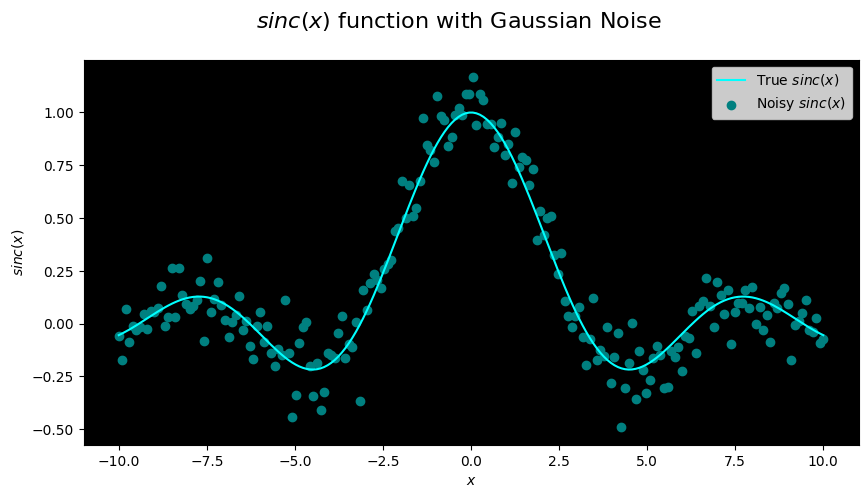

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("$sinc(x)$ function with Gaussian Noise", fontsize=16)
ax.plot(data_points, true_data, color="cyan", label="True $sinc(x)$")
ax.set_xlabel("$x$")
ax.set_ylabel("$sinc(x)$")
ax.scatter(data_points, noisy_data, color="teal", label="Noisy $sinc(x)$")
ax.set_facecolor("black")
ax.legend()
plt.show()

In [9]:
data_points = data_points.view(-1, 1)
noisy_data = noisy_data.view(-1, 1)
# there are 200 samples, each with 1 feature.

# Multilayer Perceptron

In [10]:
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.nn as nn

dataset = TensorDataset(data_points, noisy_data) # each element of the data points and noisy data are wrapped into a dataset object: (input, target) pairs

### Why need batches?

- Train **efficiently** in memory.
- Update weights **more frequently**. 
- **Learn faster** with generalization benefits.

In [11]:
# Number of Samples processed at once (Mini batch gradient descent)
batch_size = 32 # can be tweaked to 64 aswell or 128

valid_size = 0.2

num_train = len(dataset)
indices = list(range(num_train))

# To ensure the split is unbiased
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

# 80% of the dataset for training and 20% for validation
train_index, valid_index = indices[split:], indices[:split]

# Contains only selected dataset from the original dataset
train_dataset = Subset(dataset, train_index)
valid_dataset = Subset(dataset, valid_index)

- `Dataset : **Collection Of Data**
- `DataLoader : **Iterator that feeds data in batches**

In [12]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True) # shuffles data at each epoch
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [13]:
# data_points.size()

In [14]:
# class which inherits from nn.Module, initializes and defines the layers, how many neurons and the activation stuff.
class PyTorchMLP(nn.Module):
    
    def __init__(self, num_features: int, num_outputs: int):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(

            # Input -> 1st hidden layer
            
            # Fully connected layer (y = Wx + b)
            nn.Linear(num_features, 16),
            
            # Activation function to add non-linearity: max(0, x)
            nn.ReLU(),

            # 1st hidden layer -> 2nd hidden layer
            nn.Linear(16, 32),
            nn.ReLU(),

            # 2nd hidden layer -> output layer
            nn.Linear(32, num_outputs),
        )
        
    def forward(self, x: torch.Tensor):
        '''
        forward() is just how you input the data and move it through the layers to get the final output.
        So, model(x) is same as model.forward(x)
        '''
        logits = self.linear_relu_stack(x)
        return logits # raw output of the neural network before applying the final activation function
        

In [15]:
# Instantiating the MLP model
model = PyTorchMLP(num_features=1, num_outputs=1) # creating an instance of the model; regression kinda

In [16]:
# Hyperparameters
learning_rate = 0.01
n_epochs = 100

In [17]:
# specifying the loss function : Mean Squared Error
criterion = nn.MSELoss()

# specify optimizer (stochastic gradient descent) 
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

### torch.optim.SGD
- SGD = Stochastic Gradient Descent
- optimization algorithm that updates weights using the gradient of the loss function.

### model.parameters()
- This gets all trainable parameters (weights and biases) in the model.
- Those will be updated (learned) during training.

### learning rate
- a hyperparameter that controls how much the optimizer changes the weights during each update.


In [18]:
# keeps track of training loss
train_losses = []

for epoch in range(n_epochs):

    # Training mode
    model.train()
    running_loss = 0.0
   
    for batch in train_loader:
        # for each batch
        inputs, targets = batch

        # Zero Gradients before the backward pass, no accumulation from the prev step
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate batch loss
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")


Epoch [25/100], Loss: 0.1018
Epoch [50/100], Loss: 0.0750
Epoch [75/100], Loss: 0.0653
Epoch [100/100], Loss: 0.0604


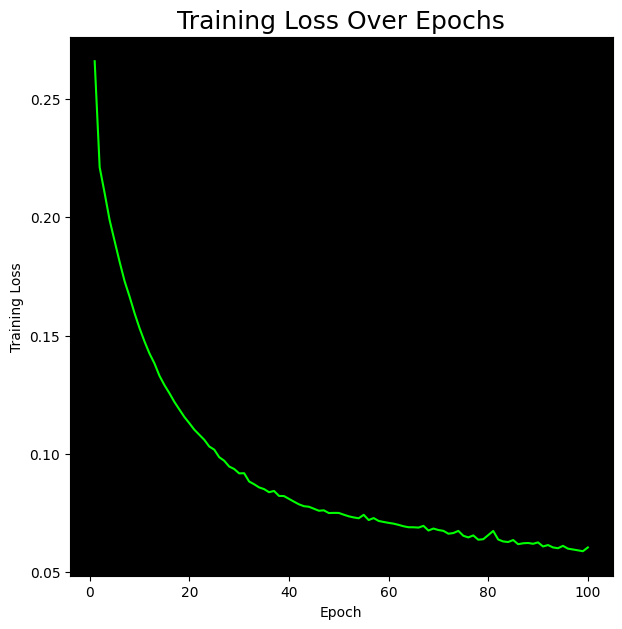

In [19]:
# PLot of learning curve
epochs = range(1, n_epochs+1)

plt.figure(figsize=(7, 7))
plt.plot(epochs, train_losses, "lime")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs', fontsize=18)
plt.gca().set_facecolor("black")
plt.show()

In [20]:
# minimum and maximum from the 1D data
x_min, x_max = data_points.min() - 1, data_points.max() + 1

# 1D grid (like a mesh, but 1D)
x_grid = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
x_grid, _ = np.meshgrid(x_grid, [0])

# Convert to tensor
x_tensor = torch.tensor(x_grid.reshape(-1, 1), dtype=torch.float32)

In [21]:
# Evaluation mode
model.eval()

with torch.no_grad():
    predictions = model(x_tensor).numpy()


## model.eval():

- Makes BatchNorm use the running average learned during training, not the current batch.
- Since, During Inference, we don't need grad, we predict by with **torch.no_grad()**

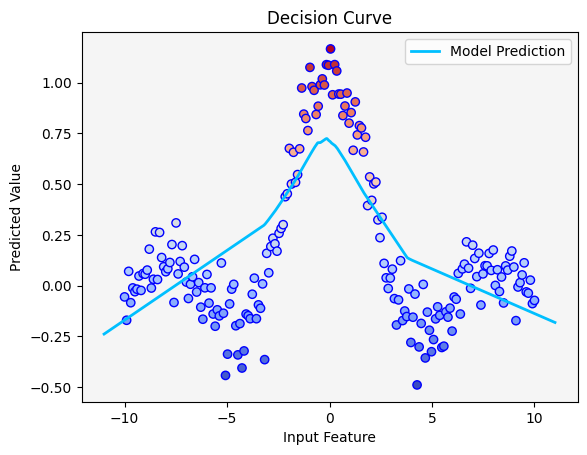

In [22]:
# Plot the predicted probability curve
plt.plot(x_grid.reshape(-1), predictions, color='deepskyblue', linewidth=2, label='Model Prediction')

# Plot the training points
plt.scatter(data_points, noisy_data, c=noisy_data, cmap=plt.cm.coolwarm, edgecolors='b')

plt.xlabel("Input Feature")
plt.ylabel("Predicted Value")
plt.title("Decision Curve")
plt.legend()
plt.gca().set_facecolor("whitesmoke")
plt.show()

# CNN with PyTorch

## DataSet Curation

In [23]:
import os
from PIL import Image
from torch.utils.data import Dataset

# Dataset preparation
class RockPaperScissors(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_index = {}

        for root, dirs, files in os.walk(root_dir):
            
            class_name = os.path.basename(root)
            
            if root == root_dir:
                continue   
            if class_name not in self.class_to_index:
                self.class_to_index[class_name] = len(self.class_to_index)
                # {'paper': 0, 'rock': 1, 'scissors': 2}
                
            label = self.class_to_index[class_name]

            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int):
        
        image = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, self.labels[index]
        

In [24]:
# # Downloading the dataset from the kaggle datasets
# !kaggle datasets download -d drgfreeman/rockpaperscissors
# !unzip -q rockpaperscissors.zip -d data/

In [25]:
from torchvision import transforms

# image to pixels of the mentioned size to tensor
transform = transforms.Compose([
    transforms.Resize([128, 128]), # resizing every image to be uniformly of (128 x 128 pixels) same size
    transforms.ToTensor(), # normalizes from (0, 255) to (0, 1)
    transforms.Normalize(mean=[0.485, 0.421, 0.444], std=[0.234, 0.211, 0.289])
])

# rock_paper_scissors_dataset
rpc_dataset = RockPaperScissors(root_dir='./data', transform=transform)

print("Class and Index:", rpc_dataset.class_to_index)

Class and Index: {'paper': 0, 'rock': 1, 'scissors': 2}


In [26]:
# shuffling and splitting into 80% training dataset and 20% validation dataset
test_size = 0.2

num_samples = len(rpc_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)

split = int(np.floor(test_size * num_samples))
train_indices, test_indices = indices[split:], indices[:split]

rpc_train_dataset = Subset(rpc_dataset, train_indices)
rpc_test_dataset = Subset(rpc_dataset, test_indices)

In [27]:
rpc_train_loader = DataLoader(rpc_train_dataset, batch_size=32, shuffle=True)
rpc_test_loader = DataLoader(rpc_test_dataset, batch_size=32)

## Convolution—nothing but a patchy operation
- —has a kernel gliding across an image, multiplying and summing pixel values to extract features like edges and textures.
- It outputs a feature map that helps a CNN spot and learn important patterns.

In [28]:
class SimpleCNN(nn.Module):
    
    def __init__(self, input_shape: int, output_shape: int,
                kernel_size: int = 3,
                stride: int = 1,
                padding: int = 1):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape, # 3 (RGB)
                               out_channels=output_shape, #  single feature map
                               kernel_size=kernel_size, # 3x3 filter
                               stride=stride, # filter moves 1 pixel at a time
                               padding=padding # adding pixel around the input
                              )
    def forward(self, x):
        return self.conv1(x)
        

## kernel 
- It's the square window (a filter) that slides over the image.
## stride
- how far the filter jumps when moving across the image

In [29]:
# Sample input: batch of 1 image, 3 channels (RGB) , 128x128
example_image = torch.randn(1, 3, 128, 128)

# Instantiating
CNN_model = SimpleCNN(input_shape=3, output_shape=1)
output = CNN_model(example_image)

print("Input shape:", example_image.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


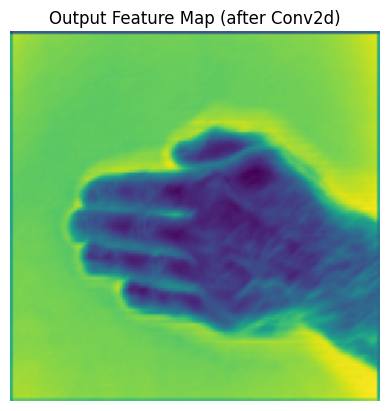

In [30]:
img_tensor, _ = rpc_dataset[0]
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension of size 1 in 0th position (ex: (1, 3, 128, 128), here (batch, C, H, W))

CNN_model.eval()
with torch.no_grad():
    feature_map = CNN_model(img_tensor)

# Visualizing the output (feature map)
# [0, 0] first image of the batch and the first and only channel
plt.imshow(feature_map[0, 0], cmap='viridis')
plt.title("Output Feature Map (after Conv2d)")
plt.axis(False)
plt.show()

- For a 3-channel input (RGB image) and 1 output channel, we need 3 kernels (one for each channel: Red, Green, Blue).
#### **Shape of kernel**	
- Must be (out_channels, in_channels, kernel_height, kernel_width) → (1, 3, 3, 3)
#### **repeat(1, 3, 1, 1)**	
- Expands the base 3×3 kernel to apply it on all input channels
#### **bias.data.zero_()**	
- Removes bias effect for pure kernel filtering

In [31]:
def image_show(image_tensor: torch.Tensor, base_kernel: torch.Tensor, title: str):
    
    # If base_kernel is 2D (3x3), make it 4D (1, 3, 3, 3)
    if base_kernel.ndim == 2:
        base_kernel = base_kernel.unsqueeze(0).unsqueeze(0)  # (1, 1, 3, 3)

    # Repeat kernel across input channels
    # Final shape: (1, 3, 3, 3)
    base_kernel = base_kernel.repeat(1, 3, 1, 1)
    
    # Update the custom kernel to CNN
    CNN_model.conv1.weight.data = base_kernel # assigns the convolution weights to the base kernel
    CNN_model.conv1.bias.data.zero_() # no bias is added
    
    # Predict
    # Apply model
    CNN_model.eval()
    with torch.no_grad():
        feature_map = CNN_model(image_tensor)
    
    # Visualize
    plt.imshow(feature_map[0, 0].numpy(), cmap='viridis') # can be changed into 'gray' 
    plt.title(f"{title}")
    plt.axis(False)
    plt.show()

In [32]:
edge_kernel = torch.tensor([[1, 0, -1],
                            [0,  0, 0],
                            [-1, 0, 1]], dtype=torch.float32)

sobel_kernel = torch.tensor([[[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]]], dtype=torch.float32).unsqueeze(0)

blur_kernel = torch.tensor([[[1/9, 1/9, 1/9],
                             [1/9, 1/9, 1/9],
                             [1/9, 1/9, 1/9]]], dtype=torch.float32).unsqueeze(0)

sharpen_kernel = torch.tensor([[[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]]], dtype=torch.float32).unsqueeze(0)


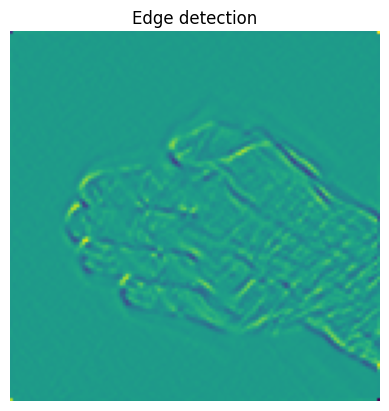

In [33]:
image_show(img_tensor, edge_kernel, "Edge detection")

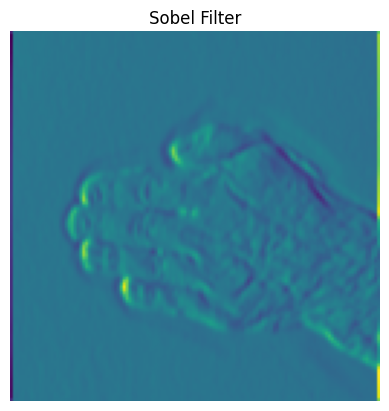

In [34]:
image_show(img_tensor, sobel_kernel, "Sobel Filter")

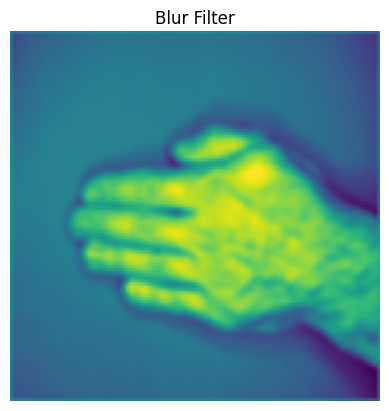

In [35]:
image_show(img_tensor, blur_kernel, "Blur Filter")

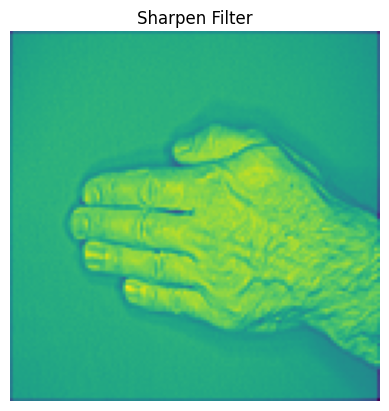

In [36]:
image_show(img_tensor, sharpen_kernel, "Sharpen Filter")

In [37]:
CNN_model2 = SimpleCNN(3, 1, kernel_size=5, stride=2, padding=2)
CNN_model3 = SimpleCNN(3, 1, kernel_size=7, stride=1, padding=0)

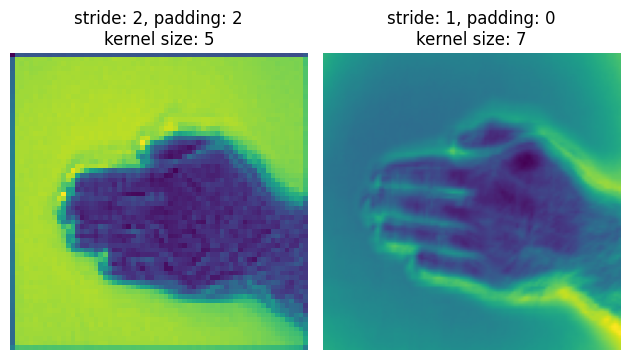

In [38]:
CNN_model2.eval()
with torch.no_grad():
    feature_map_model2 = CNN_model2(img_tensor)
    
CNN_model3.eval()  
with torch.no_grad():
    feature_map_model3 = CNN_model3(img_tensor)

plt.subplot(1, 2, 1)
plt.imshow(feature_map_model2[0, 0], cmap='viridis')
plt.title("stride: 2, padding: 2\nkernel size: 5")
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(feature_map_model3[0, 0], cmap='viridis')
plt.title("stride: 1, padding: 0\nkernel size: 7")
plt.axis(False)
plt.tight_layout()
plt.show()

## Pooling retains the dominant features by reducing the redundant ones.
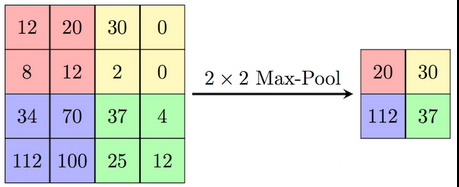

In [39]:
class PoolingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        conv_layer = self.conv(x)
        pooled = self.pool(conv_layer)
        return conv_layer, pooled

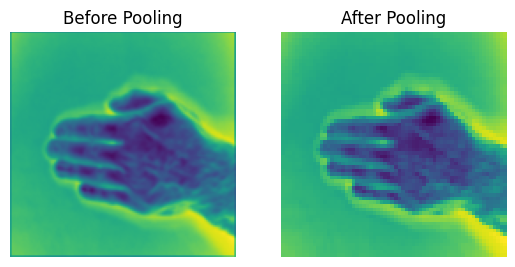

In [40]:
Pool_model = PoolingCNN()

Pool_model.eval()
with torch.no_grad():
    conv_out, pooled_out = Pool_model(img_tensor)
    

plt.subplot(1, 2, 1)
plt.imshow(conv_out[0, 0], cmap='viridis')
plt.title("Before Pooling")
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(pooled_out[0, 0], cmap='viridis')
plt.title("After Pooling")
plt.axis(False)
plt.show()

In [41]:
print("Shape Before pooling:", conv_out.shape)
print("Shape After pooling:", pooled_out.shape)

Shape Before pooling: torch.Size([1, 1, 128, 128])
Shape After pooling: torch.Size([1, 1, 64, 64])


**Before Pooling**
- High spatial resolution, preserving fine details
  
**After Pooling**
- Lower resolution, dominant features are kept, but fine details are reduced. 

## Global Average Pooling (GAP) reduces each feature map to a single value by averaging all its pixels.
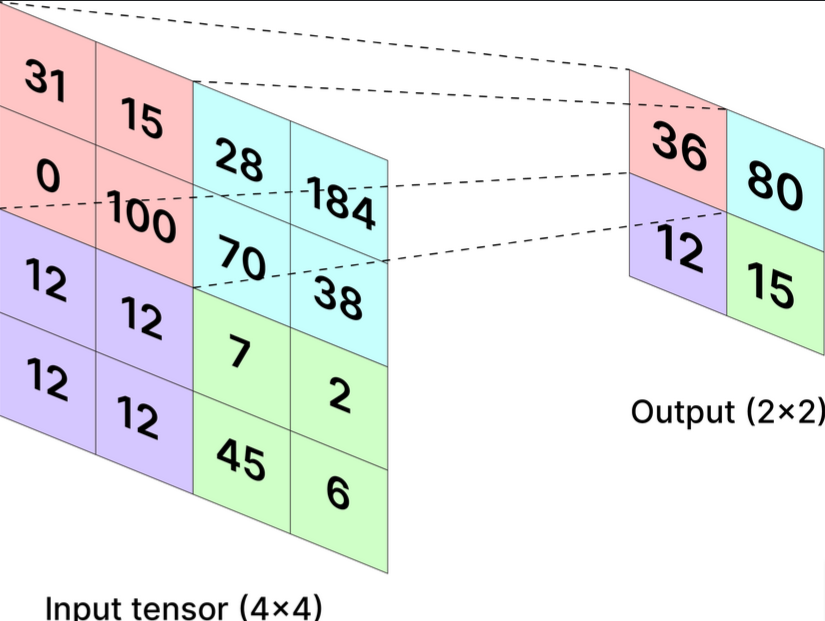

In [42]:
class SimpleGAP_CNN(nn.Module):
    
    def __init__(self, num_features, num_outputs):
        super().__init__()

        # Global Average pooling
        self.conv = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)  # 3 output channels for 3 classes
        self.gap = nn.AdaptiveAvgPool2d(1) 
    
    def forward(self, x):
        x = self.conv(x)
        x_before = x.clone()
        x = self.gap(x)  # Shape: (batch_size, 128, 1, 1)
        x_after = x.view(x.size(0), -1)  
        return x_before, x_after  # Final output layer

gap_model=SimpleGAP_CNN(num_features=3, num_outputs=1)


gap_model.eval()
with torch.no_grad():
  before_gap, after_gap=gap_model(img_tensor)

print("Shape Before applying GAP:", before_gap.shape)
print("Shape After applying GAP:", after_gap.shape)

Shape Before applying GAP: torch.Size([1, 3, 128, 128])
Shape After applying GAP: torch.Size([1, 3])


GAP takes a 4D input [N, C, H, W] and reduces it to a 2D output [N, C] by averaging each channel's spatial dimensions.

## Rock Paper Scissors Classifier

In [58]:
class RockPaperScissorsCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extraction
        self.conv1_layer = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2_layer = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3_layer = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # DownSampling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        # Fully connected layer
        self.mlp = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv1_layer(x)
       # print("After Conv1:", x.shape)
        x = self.conv2_layer(x)
       # print("After Conv2:", x.shape)
        x = self.conv3_layer(x)
       # print("After Convolutional Layer:", x.shape)

        x = self.gap(x)
       # print("After Pooling Layer (GAP: Subsampling):", x.shape)
        x = x.view(x.size(0), -1)  # Flatten
       # print("After Flatten:", x.shape)

        x = self.mlp(x)
       # print("After MLP:", x.shape)

        return x

In [54]:
def model_shapes(model, sample_input):
    x = sample_input
    print("Input Shape:", x.shape)

    # Conv1 Layer Breakdown
    x = model.conv1_layer[0](x)
    print("After Convoltion layer 1 (Conv2d):", x.shape)
    x = model.conv1_layer[1](x)
    print("After Convoltion layer 1 (ReLU):", x.shape)
    x = model.conv1_layer[2](x)
    print("After Convoltion layer 1 (MaxPool):", x.shape)

    # Conv2 Layer Breakdown
    x = model.conv2_layer[0](x)
    print("After Convoltion layer 2 (Conv2d):", x.shape)
    x = model.conv2_layer[1](x)
    print("After Convoltion layer 2 (ReLU):", x.shape)
    x = model.conv2_layer[2](x)
    print("After Convoltion layer 2 (MaxPool):", x.shape)

    # Conv3 Layer Breakdown
    x = model.conv3_layer[0](x)
    print("After Convoltion layer 3 (Conv2d):", x.shape)
    x = model.conv3_layer[1](x)
    print("After Convoltion layer 3 (ReLU):", x.shape)
    x = model.conv3_layer[2](x)
    print("After Convoltion layer 3 (MaxPool):", x.shape)

    # Global Average Pooling
    x = model.gap(x)
    print("After Global Average Pooling (GAP):", x.shape)

    # Flatten
    x = x.view(x.size(0), -1)
    print("After Flatten:", x.shape)

    # MLP
    x = model.mlp[0](x)
    print("After MLP Linear1 (128-dim):", x.shape)
    x = model.mlp[1](x)
    print("After MLP ReLU:", x.shape)
    x = model.mlp[2](x)
    print("After MLP Linear2 (Final Output):", x.shape)


In [45]:
def train_model(base_model: nn.Module,
                train_loader: DataLoader, test_loader: DataLoader,
                num_epochs: int = 10, lr: float = 0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(base_model.parameters(), lr=lr, momentum=0.9) # momentum, accelearates learning (perhaps converges well with suitable parameters)

    # keeps track of training accuracy
    train_accs = []

    # keeps track of test accuracy
    test_accs = []

    for epoch in range(num_epochs):

        # training the model
        base_model.train()
        correct = total = 0

        for imgs, labels in train_loader:
            outputs = base_model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accurate predictions, whether the predicted output is same as the ground truth
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_accs.append(train_acc)

        # testing the model
        base_model.eval()
        correct = total = 0
        
        with torch.no_grad():
            for imgs, labels in test_loader:
                outputs = base_model(imgs)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
        
        if epoch == num_epochs - 1:
            # After training loop ends
            print("\n", "="*50)
            print(f"Final Epoch -> Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}")
            print(f"Best Test Accuracy: {max(test_accs):.2f}")
            print("="*50)


    return train_accs, test_accs


In [46]:
def plot_accuracies(train_accs, test_accs):
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Testing Accuracy")
    plt.legend()
    plt.grid(False)
    plt.show()

In [47]:
n_epochs = 10
learning_rate = 0.01

Epoch 1: Train Acc = 0.3518, Test Acc = 0.3455
Epoch 2: Train Acc = 0.3746, Test Acc = 0.4302
Epoch 3: Train Acc = 0.4580, Test Acc = 0.4805
Epoch 4: Train Acc = 0.5288, Test Acc = 0.5469
Epoch 5: Train Acc = 0.5220, Test Acc = 0.5812
Epoch 6: Train Acc = 0.6282, Test Acc = 0.6362
Epoch 7: Train Acc = 0.7013, Test Acc = 0.6522
Epoch 8: Train Acc = 0.7596, Test Acc = 0.8604
Epoch 9: Train Acc = 0.8652, Test Acc = 0.9359
Epoch 10: Train Acc = 0.9081, Test Acc = 0.9748

Final Epoch -> Train Accuracy: 0.91, Test Accuracy: 0.97
Best Test Accuracy: 0.97


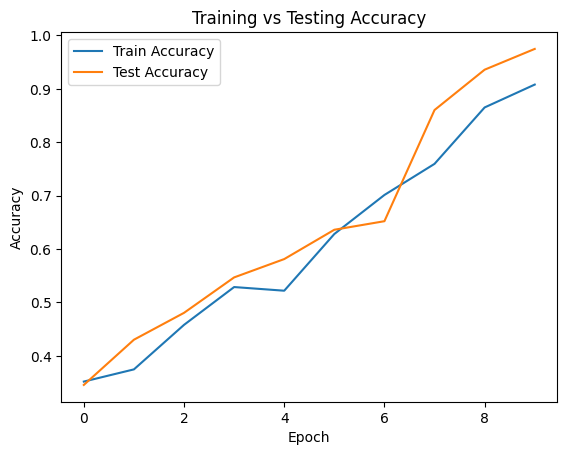

In [48]:
RPS_model = RockPaperScissorsCNN()
train_accs, test_accs = train_model(RPS_model, rpc_train_loader, rpc_test_loader,
                                    num_epochs=n_epochs, lr=learning_rate)
plot_accuracies(train_accs, test_accs)

### Why Did the Model Converge So Quickly?
- Perhaps, One major contributing factor to this rapid convergence is likely the use of **momentum in the optimizer**.

The optimizer used was `torch.optim.SGD` with `momentum=0.9`. Momentum helps accelerate the optimizer in directions of consistent gradient descent (referrring from the pytorch official documentation https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
#### Additional Contributing Factors:
- **Learning rate** of `0.01`, which balances speed and stability
- **Appropriate batch size** 32, promoting generalization
- A **clean and well-separated dataset** (Rock-Paper-Scissors)
- A **well-designed CNN architecture** that fits the task well

Hence, the model to converge efficiently and achieve high test performance in a short number of epochs.


Running: learning rate=0.01, batch_size=16, epochs=10
Epoch 1: Train Acc = 0.3432, Test Acc = 0.2883
Epoch 2: Train Acc = 0.3501, Test Acc = 0.2952
Epoch 3: Train Acc = 0.3975, Test Acc = 0.3341
Epoch 4: Train Acc = 0.4312, Test Acc = 0.5629
Epoch 5: Train Acc = 0.5237, Test Acc = 0.5995
Epoch 6: Train Acc = 0.6305, Test Acc = 0.5904
Epoch 7: Train Acc = 0.6242, Test Acc = 0.6453
Epoch 8: Train Acc = 0.6511, Test Acc = 0.5126
Epoch 9: Train Acc = 0.6939, Test Acc = 0.6545
Epoch 10: Train Acc = 0.7681, Test Acc = 0.7780

Final Epoch -> Train Accuracy: 0.77, Test Accuracy: 0.78
Best Test Accuracy: 0.78


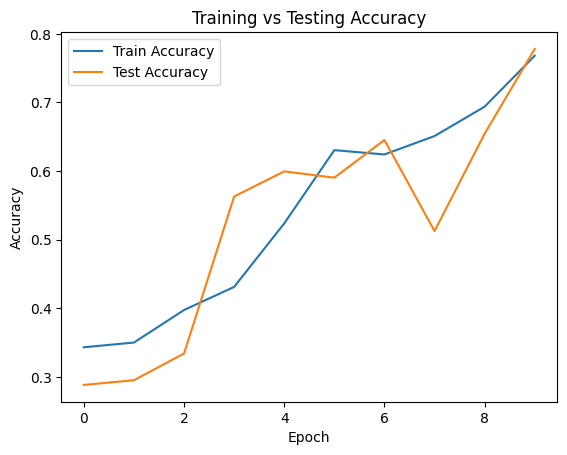


Running: learning rate=0.01, batch_size=16, epochs=20
Epoch 1: Train Acc = 0.3495, Test Acc = 0.2883
Epoch 2: Train Acc = 0.3621, Test Acc = 0.2906
Epoch 3: Train Acc = 0.3815, Test Acc = 0.3707
Epoch 4: Train Acc = 0.4329, Test Acc = 0.4485
Epoch 5: Train Acc = 0.5420, Test Acc = 0.5721
Epoch 6: Train Acc = 0.6059, Test Acc = 0.6224
Epoch 7: Train Acc = 0.6128, Test Acc = 0.6613
Epoch 8: Train Acc = 0.6413, Test Acc = 0.5950
Epoch 9: Train Acc = 0.6876, Test Acc = 0.6018
Epoch 10: Train Acc = 0.6996, Test Acc = 0.7757
Epoch 11: Train Acc = 0.7247, Test Acc = 0.7025
Epoch 12: Train Acc = 0.7282, Test Acc = 0.8467
Epoch 13: Train Acc = 0.8504, Test Acc = 0.9062
Epoch 14: Train Acc = 0.8766, Test Acc = 0.9725
Epoch 15: Train Acc = 0.9463, Test Acc = 0.9725
Epoch 16: Train Acc = 0.9486, Test Acc = 0.9634
Epoch 17: Train Acc = 0.9623, Test Acc = 0.9794
Epoch 18: Train Acc = 0.9629, Test Acc = 0.9771
Epoch 19: Train Acc = 0.9794, Test Acc = 0.9794
Epoch 20: Train Acc = 0.9732, Test Acc = 0

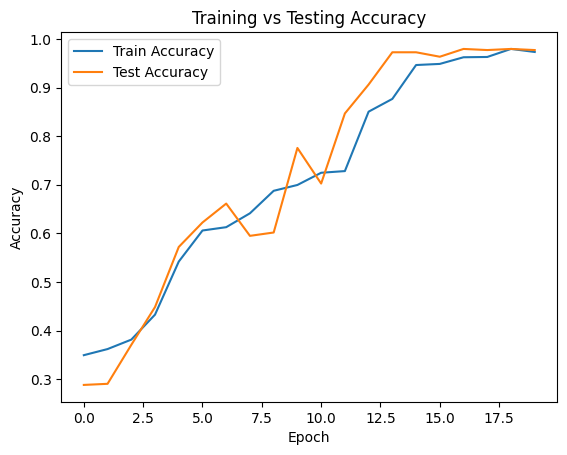


Running: learning rate=0.01, batch_size=32, epochs=10
Epoch 1: Train Acc = 0.3518, Test Acc = 0.3478
Epoch 2: Train Acc = 0.3912, Test Acc = 0.2952
Epoch 3: Train Acc = 0.4135, Test Acc = 0.5400
Epoch 4: Train Acc = 0.4700, Test Acc = 0.5789
Epoch 5: Train Acc = 0.5014, Test Acc = 0.4645
Epoch 6: Train Acc = 0.5888, Test Acc = 0.6453
Epoch 7: Train Acc = 0.6522, Test Acc = 0.5812
Epoch 8: Train Acc = 0.6716, Test Acc = 0.7231
Epoch 9: Train Acc = 0.7350, Test Acc = 0.7712
Epoch 10: Train Acc = 0.7773, Test Acc = 0.8101

Final Epoch -> Train Accuracy: 0.78, Test Accuracy: 0.81
Best Test Accuracy: 0.81


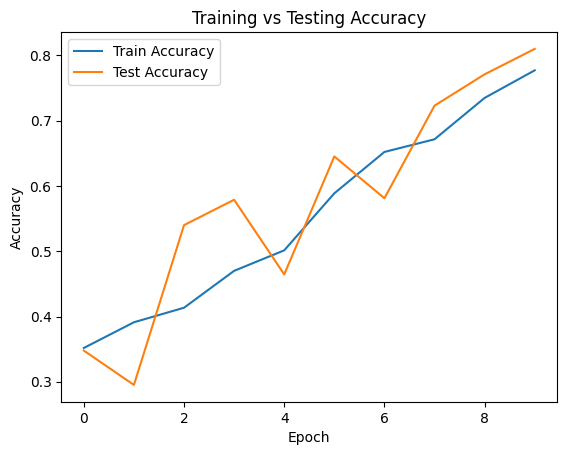


Running: learning rate=0.01, batch_size=32, epochs=20
Epoch 1: Train Acc = 0.3472, Test Acc = 0.2883
Epoch 2: Train Acc = 0.3661, Test Acc = 0.3432
Epoch 3: Train Acc = 0.4220, Test Acc = 0.4027
Epoch 4: Train Acc = 0.4557, Test Acc = 0.3913
Epoch 5: Train Acc = 0.4940, Test Acc = 0.5172
Epoch 6: Train Acc = 0.5888, Test Acc = 0.5652
Epoch 7: Train Acc = 0.6259, Test Acc = 0.6293
Epoch 8: Train Acc = 0.6967, Test Acc = 0.7025
Epoch 9: Train Acc = 0.7144, Test Acc = 0.7620
Epoch 10: Train Acc = 0.7841, Test Acc = 0.7529
Epoch 11: Train Acc = 0.8527, Test Acc = 0.9153
Epoch 12: Train Acc = 0.8915, Test Acc = 0.9634
Epoch 13: Train Acc = 0.9006, Test Acc = 0.9497
Epoch 14: Train Acc = 0.9532, Test Acc = 0.8535
Epoch 15: Train Acc = 0.9543, Test Acc = 0.9771
Epoch 16: Train Acc = 0.9709, Test Acc = 0.9703
Epoch 17: Train Acc = 0.9737, Test Acc = 0.9840
Epoch 18: Train Acc = 0.9794, Test Acc = 0.9794
Epoch 19: Train Acc = 0.9652, Test Acc = 0.9680
Epoch 20: Train Acc = 0.9652, Test Acc = 0

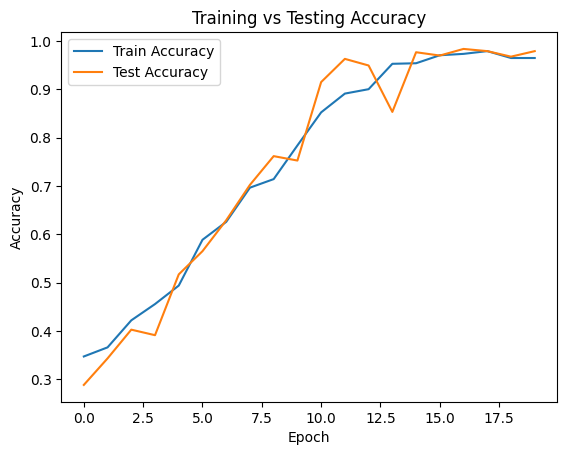


Running: learning rate=0.001, batch_size=16, epochs=10
Epoch 1: Train Acc = 0.3507, Test Acc = 0.2883
Epoch 2: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 3: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 4: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 5: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 6: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 7: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 8: Train Acc = 0.3569, Test Acc = 0.2883
Epoch 9: Train Acc = 0.3575, Test Acc = 0.2883
Epoch 10: Train Acc = 0.3575, Test Acc = 0.2906

Final Epoch -> Train Accuracy: 0.36, Test Accuracy: 0.29
Best Test Accuracy: 0.29


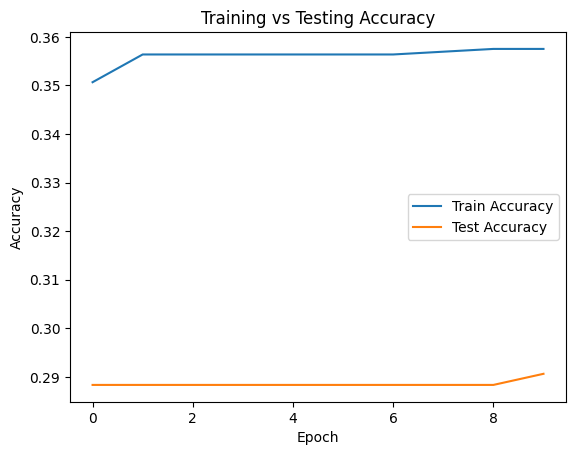


Running: learning rate=0.001, batch_size=16, epochs=20
Epoch 1: Train Acc = 0.3415, Test Acc = 0.3661
Epoch 2: Train Acc = 0.3906, Test Acc = 0.2883
Epoch 3: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 4: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 5: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 6: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 7: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 8: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 9: Train Acc = 0.3575, Test Acc = 0.2883
Epoch 10: Train Acc = 0.3575, Test Acc = 0.2883
Epoch 11: Train Acc = 0.3581, Test Acc = 0.2906
Epoch 12: Train Acc = 0.3644, Test Acc = 0.2952
Epoch 13: Train Acc = 0.3661, Test Acc = 0.2998
Epoch 14: Train Acc = 0.3718, Test Acc = 0.3112
Epoch 15: Train Acc = 0.3752, Test Acc = 0.3158
Epoch 16: Train Acc = 0.3872, Test Acc = 0.3158
Epoch 17: Train Acc = 0.4038, Test Acc = 0.3410
Epoch 18: Train Acc = 0.4209, Test Acc = 0.3867
Epoch 19: Train Acc = 0.4163, Test Acc = 0.4256
Epoch 20: Train Acc = 0.4557, Test Acc = 

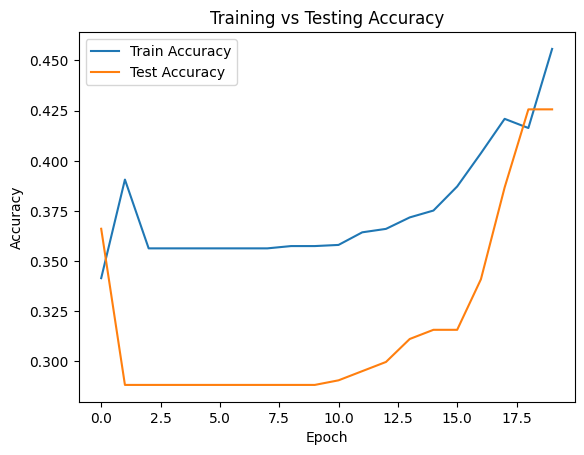


Running: learning rate=0.001, batch_size=32, epochs=10
Epoch 1: Train Acc = 0.3261, Test Acc = 0.3066
Epoch 2: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 3: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 4: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 5: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 6: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 7: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 8: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 9: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 10: Train Acc = 0.3564, Test Acc = 0.2883

Final Epoch -> Train Accuracy: 0.36, Test Accuracy: 0.29
Best Test Accuracy: 0.31


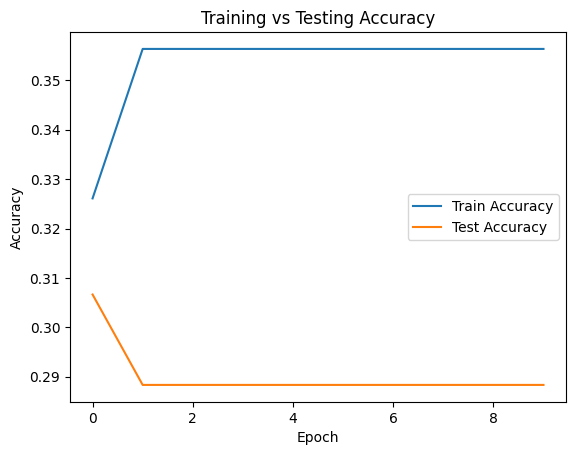


Running: learning rate=0.001, batch_size=32, epochs=20
Epoch 1: Train Acc = 0.3381, Test Acc = 0.3913
Epoch 2: Train Acc = 0.3592, Test Acc = 0.2883
Epoch 3: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 4: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 5: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 6: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 7: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 8: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 9: Train Acc = 0.3564, Test Acc = 0.2883
Epoch 10: Train Acc = 0.3569, Test Acc = 0.2883
Epoch 11: Train Acc = 0.3587, Test Acc = 0.2906
Epoch 12: Train Acc = 0.3621, Test Acc = 0.2906
Epoch 13: Train Acc = 0.3632, Test Acc = 0.2975
Epoch 14: Train Acc = 0.3672, Test Acc = 0.2975
Epoch 15: Train Acc = 0.3666, Test Acc = 0.2975
Epoch 16: Train Acc = 0.3661, Test Acc = 0.3021
Epoch 17: Train Acc = 0.3706, Test Acc = 0.3021
Epoch 18: Train Acc = 0.3786, Test Acc = 0.3227
Epoch 19: Train Acc = 0.3849, Test Acc = 0.3570
Epoch 20: Train Acc = 0.4026, Test Acc = 

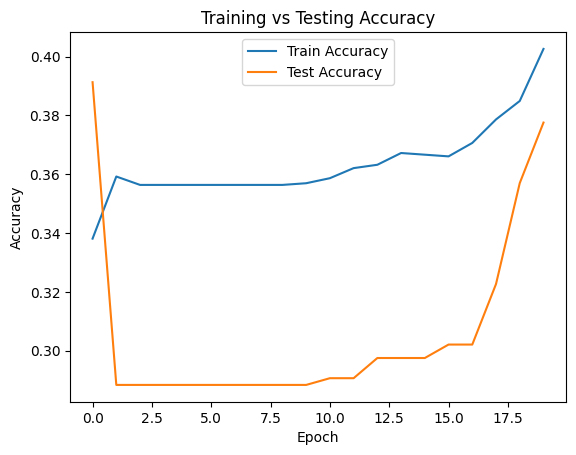

In [50]:
for learning_rate in [0.01, 0.001]:
    for batch_size in [16, 32]:
       for n_epochs in [10, 20]:
            print(f"\nRunning: learning rate={learning_rate}, batch_size={batch_size}, epochs={n_epochs}")
            
            RPS_model = RockPaperScissorsCNN()
            train_accs, test_accs = train_model(RPS_model, rpc_train_loader, rpc_test_loader,
                                                num_epochs=n_epochs, lr=learning_rate)

            plot_accuracies(train_accs, test_accs)

In [59]:
# verify the dimension after each layer in CNN
model_shapes(RPS_model, img_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
After Convoltion layer 1 (Conv2d): torch.Size([1, 64, 128, 128])
After Convoltion layer 1 (ReLU): torch.Size([1, 64, 128, 128])
After Convoltion layer 1 (MaxPool): torch.Size([1, 64, 64, 64])
After Convoltion layer 2 (Conv2d): torch.Size([1, 128, 64, 64])
After Convoltion layer 2 (ReLU): torch.Size([1, 128, 64, 64])
After Convoltion layer 2 (MaxPool): torch.Size([1, 128, 32, 32])
After Convoltion layer 3 (Conv2d): torch.Size([1, 256, 32, 32])
After Convoltion layer 3 (ReLU): torch.Size([1, 256, 32, 32])
After Convoltion layer 3 (MaxPool): torch.Size([1, 256, 16, 16])
After Global Average Pooling (GAP): torch.Size([1, 256, 1, 1])
After Flatten: torch.Size([1, 256])
After MLP Linear1 (128-dim): torch.Size([1, 128])
After MLP ReLU: torch.Size([1, 128])
After MLP Linear2 (Final Output): torch.Size([1, 3])


## The learning rate, batch size, and number of epochs all significantly impact model performance.
- A very low learning rate (e.g., 0.001) results in minimal progress, while a higher rate causes instability.
- Additionally, smaller batch sizes, like 16, tend to yield lower accuracy compared to larger batch sizes, such as 32.
- By choosing an appropriate learning rate, increasing the batch size, and allowing for more epochs (e.g., 16 or 32),
-  the model can learn effectively and generalize better.